## Modeling

In [1]:
#Google Colab needs
import os
import sys
def isCollab():
    return os.environ.get('COLAB_GPU', None) != None

if isCollab():
    #Mounting GDrive disc
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_storage = '/content/gdrive/My Drive/UCU-2019-final-project-storage'

    #Append path where custom modules stored. I put custom modules to GDrive disc
    path_to_modules = '/content/gdrive/My Drive/UCU-2019-final-project-storage'
    sys.path.append(path_to_modules)
else:
    sys.path.append('..')
    path_to_storage = None

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import numpy as np
import pickle
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import log_loss
import sys
sys.path.append('..')
from utils.func.functions import build_x, plot_roc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from joblib import dump, load
import xgboost as xgb
from sklearn.model_selection import KFold 

In [0]:
if not path_to_storage:
    path_to_storage = os.path.abspath(os.path.join(os.getcwd(), '../storage')) 

data_folder = path_to_storage+'/data/'
serialization_objects_folder = path_to_storage+'/serialization_objects/'

In [0]:
X_train = pickle.load(open(serialization_objects_folder+'X_train.p', 'rb'))
y_train = pickle.load(open(serialization_objects_folder+'y_train.p', 'rb'))

X_test = pickle.load(open(serialization_objects_folder+'X_test.p', 'rb'))
y_test = pickle.load(open(serialization_objects_folder+'y_test.p', 'rb'))

In [0]:
X_train_final = build_x(X_train, data_type='train',data_folder=serialization_objects_folder)
y_train_final =  y_train.loc[X_train_final.index]

X_test_final = build_x(X_test, data_type='test',data_folder=serialization_objects_folder)
y_test_final =  y_test.loc[X_test_final.index]

target_names = ['not duplicate', 'duplicate']

del X_train, y_train, X_test, y_test

In [6]:
X_test_final.head()

,chebyshev,braycurtis,cosine,correlation,canberra,hausdorff,cityblock,euclidean,l1,l2,...,minkowski_distance,braycurtis_distance,len_diff,token_sort_ratio,token_ratio,intersection_ratio,token_set_ratio,partial_ratio,n_capital_letters_diff,n_question_marks_diff
id,,,,,,,,,,,,,,,,,,,,,
92217,2.729636,0.759858,0.751682,0.750155,173.690816,13.259182,211.660137,15.311931,211.660137,15.311931,...,0.261045,0.300964,3,69,64,0.727273,73,64,3,0
191143,2.438973,0.799996,0.780621,0.780265,192.049100,16.955406,185.418989,13.431730,185.418989,13.431730,...,0.277733,0.325870,34,56,57,0.222222,86,71,0,0
22640,2.565702,0.792729,0.788820,0.788732,179.274516,15.473444,196.146957,14.203418,196.146957,14.203418,...,0.200047,0.216731,2,83,87,0.666667,89,85,0,0
348814,3.379172,0.829099,0.820800,0.819331,185.900484,18.955211,252.847026,18.344742,252.847026,18.344742,...,0.338221,0.406219,21,61,51,0.444444,83,57,2,1
259163,2.269326,0.863334,0.839565,0.839250,208.263951,8.215338,178.386413,13.011399,178.386413,13.011399,...,0.224956,0.257012,43,65,65,0.444444,97,93,0,0


In [7]:
len(X_train_final.columns)


29

In [8]:
X_train_final.shape, y_train_final.shape

((269633, 29), (269633,))

In [9]:
X_test_final.shape, y_test_final.shape

((132833, 29), (132833,))

### Logistic Regression

In [0]:
logr_model = LogisticRegression(random_state=42)
param_grid = {'C': np.logspace(-2, 7, 10),
             #'penalty': ['l1','l2'],
             'tol': np.logspace(-5, -1, 5),
             #'solver': ['lbfgs']
             #'max_iter': np.linspace(10, 1000, 10)
             }
logr_cv = RandomizedSearchCV(logr_model, param_distributions=param_grid, cv=5, n_jobs=-1)
logr_cv.fit(X_train_final, y_train_final)

dump(logr_cv, serialization_objects_folder+'logr_ramdomcv.joblib')

In [0]:
logr_cv = load(serialization_objects_folder+'logr_ramdomcv.joblib')

In [12]:
logr_cv.best_params_

{'C': 10.0, 'tol': 0.0001}

#### Evaluate

In [13]:
from sklearn.linear_model import LogisticRegression
logr_model = LogisticRegression(#solver=logr_cv.best_params_['solver'], 
                                random_state=42, 
                                C=logr_cv.best_params_['C'], 
                                tol=logr_cv.best_params_['tol'], 
                                #max_iter=logr_cv.best_params_['max_iter'], 
                                n_jobs=-1)
logr_model.fit(X_train_final, y_train_final)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=42, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)

In [0]:
logr_pred = logr_model.predict(X_test_final)

In [15]:
logr_pred

array([0, 1, 0, ..., 0, 0, 0])

In [16]:
logr_acc_score = accuracy_score(y_test_final, logr_pred)
logr_prec_score = precision_score(y_test_final, logr_pred)
logr_rec_score = recall_score(y_test_final, logr_pred)
logr_log_loss = log_loss(y_test_final, logr_model.predict_proba(X_test_final))
print('Logistic Regression')
print('accuracy score : {}'.format(logr_acc_score))
print('precision score : {}'.format(logr_prec_score))
print('recall score : {}'.format(logr_rec_score))
print('log loss : {}'.format(logr_log_loss))
print(classification_report(y_test_final, logr_pred, target_names=target_names))

Logistic Regression
accuracy score : 0.7519215857505288
precision score : 0.773859976267164
recall score : 0.46479188726887677
log loss : 0.4627793515862453
               precision    recall  f1-score   support

not duplicate       0.75      0.92      0.82     83725
    duplicate       0.77      0.46      0.58     49108

    micro avg       0.75      0.75      0.75    132833
    macro avg       0.76      0.69      0.70    132833
 weighted avg       0.76      0.75      0.73    132833



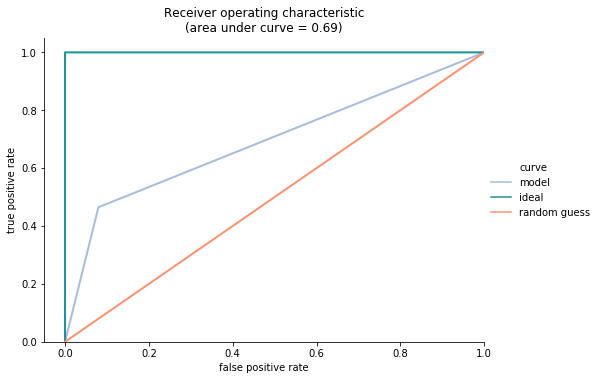

In [21]:
logr_fpr, logr_tpr, _ = roc_curve(y_test_final, logr_pred)
logr_roc_auc = auc(logr_fpr, logr_tpr)

plot_roc(logr_fpr, logr_tpr, logr_roc_auc)

### Gradient Boosted Machine (XGBoost)

In [0]:
params_xgb = {'n_estimators' : [1, 2, 4, 8, 16, 32, 64, 100, 200],
               'gamma':np.linspace(.01, 1, 10, endpoint=True), 
               'learning_rate' : np.linspace(.01, 1, 10, endpoint=True),
               'reg_lambda': np.linspace(0.01, 10, 20, endpoint=True),
               'max_depth' : np.linspace(1, 32, 32, endpoint=True, dtype=int)
                 }
cv_xgb = RandomizedSearchCV(xgb.XGBClassifier(objective='binary:logistic', random_state=42), param_distributions=params_xgb, cv=5, n_jobs=3, random_state=42)
cv_xgb.fit(X_train_final, y_train_final)
dump(cv_xgb, serialization_objects_folder+'xgb_ramdomcv.joblib')



In [0]:
cv_xgb = load(serialization_objects_folder+'xgb_ramdomcv.joblib')

In [0]:
cv_xgb.best_params_

#### Evaluate

In [0]:
clf_xgb_model = xgb.XGBClassifier(random_state=42,
                                  objective='binary:logistic',
                                  n_estimators=cv_xgb.best_params_['n_estimators'],
                                  gamma=cv_xgb.best_params_['gamma'],
                                  learning_rate=cv_xgb.best_params_['learning_rate'],
                                  reg_lambda=cv_xgb.best_params_['reg_lambda'],
                                  max_depth=cv_xgb.best_params_['max_depth'],
                                  n_jobs=-1)

t0 = time.time()
clf_xgb_model.fit(X_train_final, y_train_final)
t1 = time.time() - t0
print(t1)

In [0]:
score_xgb = accuracy_score(y_test_final, y_pred_xgb)
rscore_xgb = recall_score(y_test_final, y_pred_xgb)
pscore_xgb = precision_score(y_test_final, y_pred_xgb)
print('Accuracy score for XGBoost ', score_xgb)
print('Recall score for XGBoost ', rscore_xgb)
print('Precision score for XGBoost ', pscore_xgb)
print(classification_report(y_test_final, y_pred_xgb, target_names=target_names))

In [0]:
xgb_fpr, xgb_tpr, _ = roc_curve(y_test_final, y_pred_xgb)
xgb_roc_auc = auc(xgb_fpr, xgb_tpr)

plot_roc(xgb_fpr, xgb_tpr, xgb_roc_auc)

### LightGBM

In [0]:
!git clone --recursive https://github.com/Microsoft/LightGBM
%cd /content/LightGBM
!mkdir build
!cmake -DUSE_GPU=1 #avoid ..
!make -j$(nproc)
%cd /content/LightGBM/python-package
!sudo python setup.py install --precompile

In [0]:
import lightgbm as lgb


gkf = KFold(n_splits=5, shuffle=True, random_state=42).split(X=X_train_final, y=y_train_final)


param_grid = {
    'num_leaves': [31, 127],
    'reg_alpha': [0.1, 0.5],
    'min_data_in_leaf': [100, 200, 300],
    'learning_rate': [0.1, 0.04]
    }

lgb_estimator = lgb.LGBMClassifier(silent=False, n_jobs=-1, verbose=10, boosting_type='gbdt',  objective='binary', num_boost_round=2000, learning_rate=0.01, metric='binary_logloss', device='gpu')

gsearch = GridSearchCV(n_jobs=-1, verbose=10, estimator=lgb_estimator, param_grid=param_grid, cv=gkf)


lgb_model = gsearch.fit(X=X_train_final, y=y_train_final)
pickle.dump(lgb_model.best_params_, open(serialization_objects_folder+'lgb_model_best_params', 'wb'))


In [26]:
best_params_ = pickle.load(open(serialization_objects_folder+'lgb_model_best_params', 'rb'))
final_lgb_estimator = lgb.LGBMClassifier(
    silent=False, 
    n_jobs=-1, 
    verbose=10, 
    boosting_type='gbdt', 
    objective='binary', 
    num_boost_round=2000, 
    metric='binary_logloss', 
    device='gpu',
    learning_rate=best_params_['learning_rate'],
    min_data_in_leaf=best_params_['min_data_in_leaf'],
    num_leaves=best_params_['num_leaves'],
    reg_alpha=best_params_['reg_alpha'],
    
)

final_lgb_estimator.fit(X_train_final, y_train_final)


/content/LightGBM/python-package/lightgbm/engine.py:120: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        device='gpu', importance_type='split', learning_rate=0.04,
        max_depth=-1, metric='binary_logloss', min_child_samples=20,
        min_child_weight=0.001, min_data_in_leaf=200, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_boost_round=2000, num_leaves=31,
        objective='binary', random_state=None, reg_alpha=0.1,
        reg_lambda=0.0, silent=False, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0, verbose=10)

In [31]:
best_params_

{'learning_rate': 0.04,
 'min_data_in_leaf': 200,
 'num_leaves': 31,
 'reg_alpha': 0.1}

In [0]:
logr_pred_gbm = final_lgb_estimator.predict(X_test_final)

In [28]:
logr_acc_score = accuracy_score(y_test_final, logr_pred_gbm)
logr_prec_score = precision_score(y_test_final, logr_pred_gbm)
logr_rec_score = recall_score(y_test_final, logr_pred_gbm)
logr_log_loss = log_loss(y_test_final, final_lgb_estimator.predict_proba(X_test_final))
print('Logistic Regression')
print('accuracy score : {}'.format(logr_acc_score))
print('precision score : {}'.format(logr_prec_score))
print('recall score : {}'.format(logr_rec_score))
print('log loss : {}'.format(logr_log_loss))
print(classification_report(y_test_final, logr_pred, target_names=target_names))

Logistic Regression
accuracy score : 0.7932817899166623
precision score : 0.8121881579326854
recall score : 0.5734503543210883
log loss : 0.37493700898781807
               precision    recall  f1-score   support

not duplicate       0.75      0.92      0.82     83725
    duplicate       0.77      0.46      0.58     49108

    micro avg       0.75      0.75      0.75    132833
    macro avg       0.76      0.69      0.70    132833
 weighted avg       0.76      0.75      0.73    132833



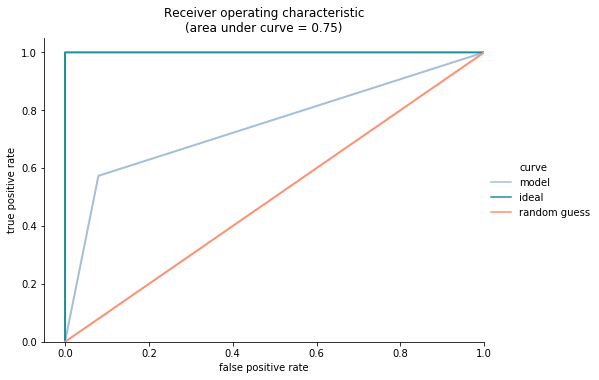

In [30]:
lgb_mlogr_fpr, logr_tpr, _ = roc_curve(y_test_final, logr_pred_gbm)
logr_roc_auc = auc(logr_fpr, logr_tpr)

plot_roc(logr_fpr, logr_tpr, logr_roc_auc)